In [1]:
import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import os
import CMBS4
import qubicplus
#import fgbuster
import fgbuster
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle

def separate(comp, instr, maps_to_separate, print_option=False):
    solver_options = {'eps':1e-5}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'L-BFGS-B', 'options': solver_options}
    try:
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res

nside=256

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap = get_coverage(0.03, nside)
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

pkl_file = open('S4_dict.pkl', 'rb')
S4_dict = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('BI_dict.pkl', 'rb')
BI_dict = pickle.load(pkl_file)
pkl_file.close()

Before we explore the component separation with FG-Buster for a simple model of dust (d0 in PySM) which leads to a modified black body with temperature $T$ and a spectral index $\beta_d$. Let's assume now a more complex model of dust. We impose now two index $\beta$ which caracterize SED between a break frequency $\nu_{break}$. 

We modify FG-Buster before in order to compute a SED with twos differents slopes. Here a defition which compute those SED.

In [2]:
# analytic expression 
analytic_expr=s4bi.double_beta_dust_FGB_Model()

betadown=1.64
betaup=1.44
beta1 = 1.54

def sed(analytic_expr, nus, beta0, beta1, nubreak, nu0, temp=20, hok=constants.h * 1e9 / constants.k):
    sed_expr = AnalyticComponent(analytic_expr, 
                             nu0=nu0, 
                             beta_d0=beta0, 
                             beta_d1=beta1, 
                             temp=temp,
                             nubreak=nubreak, 
                             h_over_k = hok)
    return nus, sed_expr.eval(nus)
nus=np.linspace(10, 400, 400)
nb=265
nu0=270
#nus, sed1b = sed(analytic_expr, nus, beta1, beta1, nubreak=nb, nu0=nu0)
#nus, sed2b = sed(analytic_expr, nus, betaup, betadown, nubreak=nb, nu0=nu0)

We construct SED caracterize by twos scalar $\beta$. We can now construct maps which follow those law. Here we try to compute maps, apply the component separation and save the results.

In [3]:
reload(qubicplus)

def run_mc(N, covmap, pixok, dict, name, nsub):
    
    inputs, inputs_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b', 'synchrotron':'s0'}, dict).getskymaps(same_resol=0.1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[betaup, betadown, nb, nu0])
    
    comp_modified = [Dust_2b(nu0=nu0, nubreak=nb), CMB(), Synchrotron(nu0=30)]
    

    # Define instrument
    instr = get_instrument(name)
    instr.fwhm = np.ones(nsub)*0.1*60
    
    #Component Separation
    r=separate(comp_modified, instr, inputs[:, :, pixok])

    print("   beta_d0 = {:.6f} beta_d1 = {:.6f} T = {:.6f} beta_s = {:.6f}".format(r.x[0], r.x[1], r.x[2], r.x[3]))
    
    return r, inputs, inputs_noiseless

r, inputs, inputs_noiseless = run_mc(1, covmap, pixok, S4_dict, 'CMBS4', 9)

> Modified Dust
> Synchrotron
   beta_d0 = 1.353657 beta_d1 = 1.530411 T = 19.996362 beta_s = -3.001725


In [4]:
import pysm3
import pysm3.units as u
from pysm3 import utils

def give_me_sync_maps(nu_ref, betapl, nu0=nu0):
    analytic_expr_syn = '(nu / nu0)**(beta_pl)'
    sync = AnalyticComponent(analytic_expr_syn, nu0=nu0, beta_pl=betapl)
    scaling_factor_sync = sync.eval(nu_ref)
    #print(scaling_factor_sync)
    
    sky=pysm3.Sky(nside=256, preset_strings=['s0'])
    sync_map_ref = np.zeros((3, 12*256**2)) #this way the output is w/0 units!!
    sync_map_ref[0:3,:]=sky.get_emission(nu_ref*u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu_ref*u.GHz))

    map_test=sync_map_ref*scaling_factor_sync

    mask = s4bi.get_coverage(fsky=0.03, nside=256, center_radec=[0., -57.])
    #print(mask)

    return map_test

The estimation of dust maps directly with FGB is not working for two $\beta$ model. So we compute them by hands

In [5]:
est_dust_maps = qubicplus.get_scaled_dust_dbmmb_map(nu_ref=nu0, nu_vec=[nu0], beta0=r.x[0], 
                                                    beta1=r.x[1], nubreak=nb, nside=256, fsky=0.03, 
                                                        radec_center=[0., -57.], temp=r.x[2])

true_dust_maps = qubicplus.get_scaled_dust_dbmmb_map(nu_ref=nu0, nu_vec=[nu0], beta0=betaup, 
                                                     beta1=betadown, nubreak=nb, nside=256, fsky=0.03, 
                                                         radec_center=[0., -57.], temp=20.)

est_sync_maps = give_me_sync_maps(nu_ref=nu0, betapl=r.x[3], nu0=nu0)

true_sync_maps = give_me_sync_maps(nu_ref=nu0, betapl=-3, nu0=nu0)

est_sync_maps = hp.sphtfunc.smoothing(est_sync_maps, fwhm=np.deg2rad(0.1),verbose=False)
true_sync_maps = hp.sphtfunc.smoothing(true_sync_maps, fwhm=np.deg2rad(0.1),verbose=False)

est_dust_maps = hp.sphtfunc.smoothing(est_dust_maps[0], fwhm=np.deg2rad(0.1),verbose=False)
true_dust_maps = hp.sphtfunc.smoothing(true_dust_maps[0], fwhm=np.deg2rad(0.1),verbose=False)


istk=1
true_dust_maps[:, ~pixok] = hp.UNSEEN
est_dust_maps[:, ~pixok] = hp.UNSEEN

true_sync_maps[:, ~pixok] = hp.UNSEEN
est_sync_maps[:, ~pixok] = hp.UNSEEN

cmbs4=qubicplus.BImaps({'cmb':42}, S4_dict).get_cmb()

cmbs4 = hp.sphtfunc.smoothing(cmbs4, fwhm=np.deg2rad(0.1),verbose=False)
cmbs4[:, ~pixok] = hp.UNSEEN


In [6]:
true_dust_maps.shape

(3, 786432)

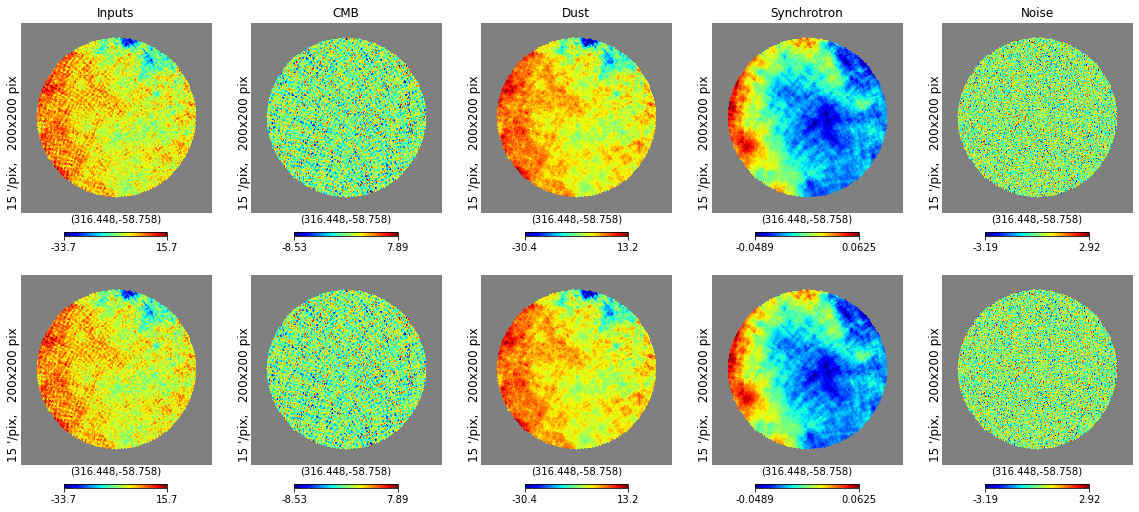

In [7]:
istk=2
plt.figure(figsize=(16, 7))
hp.gnomview(inputs[8, istk], rot=center, reso=15, sub=(2, 5, 1), title='Inputs', cmap='jet')
hp.gnomview(cmbs4[istk], rot=center, reso=15, sub=(2, 5, 2), title='CMB', cmap='jet')
hp.gnomview(true_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 3), title='Dust', cmap='jet')
hp.gnomview(true_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 4), title='Synchrotron', cmap='jet')
res_true = inputs[8, istk] - true_dust_maps[istk] - true_sync_maps[istk] - cmbs4[istk]
res_true[~pixok] = hp.UNSEEN
hp.gnomview(res_true, rot=center, reso=15, sub=(2, 5, 5), title='Noise', cmap='jet')


hp.gnomview(inputs[8, istk], rot=center, reso=15, sub=(2, 5, 6), title='', cmap='jet')
hp.gnomview(cmbs4[istk], rot=center, reso=15, sub=(2, 5, 7), title='', cmap='jet')
hp.gnomview(est_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 8), title='', cmap='jet')
hp.gnomview(est_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 9), title='', cmap='jet')
ress4=inputs[8, istk] - est_dust_maps[istk] - est_sync_maps[istk] - cmbs4[istk]
ress4[~pixok] = hp.UNSEEN
hp.gnomview(ress4, rot=center, reso=15, sub=(2, 5, 10), title='', cmap='jet')
plt.show()

In [8]:
rbi, inputsbi, inputsbi_noiseless = run_mc(1, covmap, pixok, BI_dict, 'Qubic+', 45)

> Modified Dust
> Synchrotron
   beta_d0 = 1.340115 beta_d1 = 1.740923 T = 20.001482 beta_s = -3.000063


In [9]:
est_bi_dust_maps = qubicplus.get_scaled_dust_dbmmb_map(nu_ref=nu0, nu_vec=[nu0], beta0=rbi.x[0], 
                                                    beta1=rbi.x[1], nubreak=nb, nside=256, fsky=0.03, 
                                                        radec_center=[0., -57.], temp=rbi.x[2])

true_bi_dust_maps = qubicplus.get_scaled_dust_dbmmb_map(nu_ref=nu0, nu_vec=[nu0], beta0=betaup, 
                                                     beta1=betadown, nubreak=nb, nside=256, fsky=0.03, 
                                                         radec_center=[0., -57.], temp=20.)

est_bi_sync_maps = give_me_sync_maps(nu_ref=nu0, betapl=rbi.x[3], nu0=nu0)

true_bi_sync_maps = give_me_sync_maps(nu_ref=nu0, betapl=-3, nu0=nu0)

est_bi_sync_maps = hp.sphtfunc.smoothing(est_bi_sync_maps, fwhm=np.deg2rad(0.1),verbose=False)
true_bi_sync_maps = hp.sphtfunc.smoothing(true_bi_sync_maps, fwhm=np.deg2rad(0.1),verbose=False)

est_bi_dust_maps = hp.sphtfunc.smoothing(est_bi_dust_maps[0], fwhm=np.deg2rad(0.1),verbose=False)
true_bi_dust_maps = hp.sphtfunc.smoothing(true_bi_dust_maps[0], fwhm=np.deg2rad(0.1),verbose=False)


istk=1
true_bi_dust_maps[:, ~pixok] = hp.UNSEEN
est_bi_dust_maps[:, ~pixok] = hp.UNSEEN

true_bi_sync_maps[:, ~pixok] = hp.UNSEEN
est_bi_sync_maps[:, ~pixok] = hp.UNSEEN

cmbbi=qubicplus.BImaps({'cmb':42}, BI_dict).get_cmb()

cmbbi = hp.sphtfunc.smoothing(cmbbi, fwhm=np.deg2rad(0.1),verbose=False)
cmbbi[:, ~pixok] = hp.UNSEEN

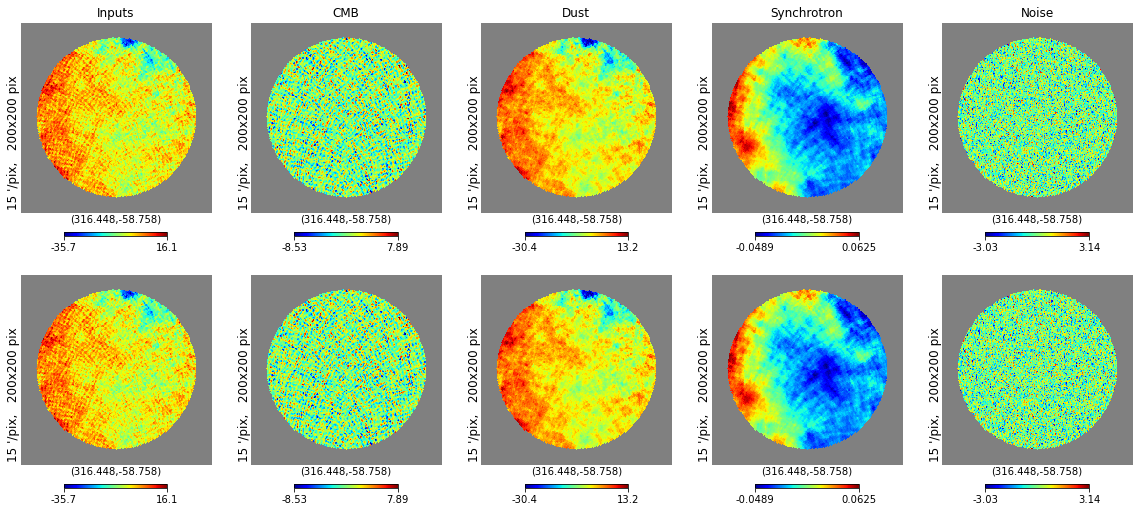

In [16]:
istk=2
plt.figure(figsize=(16, 7))
hp.gnomview(inputsbi[42, istk], rot=center, reso=15, sub=(2, 5, 1), cmap='jet', title='Inputs')
hp.gnomview(cmbbi[istk], rot=center, reso=15, sub=(2, 5, 2), cmap='jet', title='CMB')
hp.gnomview(true_bi_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 3), cmap='jet', title='Dust')
hp.gnomview(true_bi_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 4), cmap='jet', title='Synchrotron')
res_true = inputsbi[42, istk] - true_bi_dust_maps[istk] - true_bi_sync_maps[istk] - cmbbi[istk]
res_true[~pixok] = hp.UNSEEN
hp.gnomview(res_true, rot=center, reso=15, sub=(2, 5, 5), cmap='jet', title='Noise')


hp.gnomview(inputsbi[42, istk], rot=center, reso=15, sub=(2, 5, 6), cmap='jet', title='')
hp.gnomview(cmbbi[istk], rot=center, reso=15, sub=(2, 5, 7), cmap='jet', title='')
hp.gnomview(est_bi_dust_maps[istk], rot=center, reso=15, sub=(2, 5, 8), cmap='jet', title='')
hp.gnomview(est_bi_sync_maps[istk], rot=center, reso=15, sub=(2, 5, 9), cmap='jet', title='')
resbi=inputsbi[42, istk] - est_bi_dust_maps[istk] - est_bi_sync_maps[istk] - cmbbi[istk]
resbi[~pixok] = hp.UNSEEN
hp.gnomview(resbi, rot=center, reso=15, sub=(2, 5, 10), title='', cmap='jet')
plt.show()

# Check for all nubreak

In [11]:
def check_nubreak(betaup, betadown, N):
    nb = np.linspace(10, 280, N)
    betad0_s4 = []
    betad1_s4 = []
    betad0_bi = []
    betad1_bi = []
    
    for ind_nub, nub in enumerate(nb):
        print('nubreak = {:.2f}'.format(nub))
        cmbdust_s4_modified, _, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b'}, S4_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[betaup, betadown, nub])
        
        cmbdust_bi_modified, _, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[betaup, betadown, nub])
    
        comp_modified = [Dust_2b(nu0=nu0, nubreak=nub, temp=20), CMB()]

        # Define instrument
        instr = get_instrument('CMBS4')
        instr.fwhm = np.ones(9)*1*60
    
        #Component Separation

        r_s4_modified=separate(comp_modified, instr, cmbdust_s4_modified[:, :, pixok])
        
        # Define instrument
        instr = get_instrument('Qubic+')
        instr.fwhm = np.ones(45)*1*60
    
        #Component Separation

        r_bi_modified=separate(comp_modified, instr, cmbdust_bi_modified[:, :, pixok])
        
        betad0_s4.append(r_s4_modified.x[0])
        betad1_s4.append(r_s4_modified.x[1])
        betad0_bi.append(r_bi_modified.x[0])
        betad1_bi.append(r_bi_modified.x[1])
    
    return nb, betad0_s4, betad1_s4, betad0_bi, betad1_bi

In [12]:
import pickle

with open('results/MC_allnubreak_N10_nbexp10.pkl', 'rb') as f:
    data = pickle.load(f)

nubreak=data['nubreak']
mbeta0_s4 = np.mean(data['beta0_s4'], axis=1)
mbeta0_bi = np.mean(data['beta0_bi'], axis=1)
mbeta1_s4 = np.mean(data['beta1_s4'], axis=1)
mbeta1_bi = np.mean(data['beta1_bi'], axis=1)

sbeta0_s4 = np.std(data['beta0_s4'], axis=1)
sbeta0_bi = np.std(data['beta0_bi'], axis=1)
sbeta1_s4 = np.std(data['beta1_s4'], axis=1)
sbeta1_bi = np.std(data['beta1_bi'], axis=1)

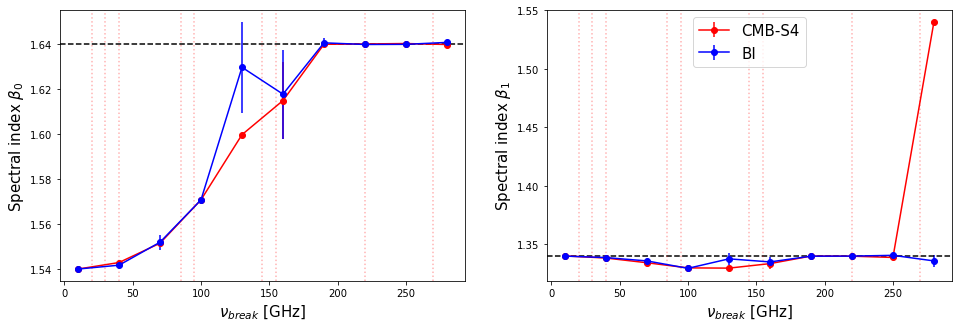

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.errorbar(nubreak, mbeta0_s4, yerr=sbeta0_s4, fmt='o-r')
plt.errorbar(nubreak, mbeta0_bi, yerr=sbeta0_bi, fmt='o-b')
plt.axhline(1.64, ls='--', color='black')
plt.xlabel(r'$\nu_{break}$ [GHz]', fontsize=15)
plt.ylabel(r'Spectral index $\beta_0$', fontsize=15)
for i in range(9):
    plt.axvline(S4_dict['frequency'][i], ls=':', color='red', alpha=0.3)
plt.subplot(1, 2, 2)
plt.errorbar(nubreak, mbeta1_s4, yerr=sbeta1_s4, fmt='o-r', label='CMB-S4')
plt.errorbar(nubreak, mbeta1_bi, yerr=sbeta1_bi, fmt='o-b', label='BI')
plt.axhline(1.34, ls='--', color='black')
plt.xlabel(r'$\nu_{break}$ [GHz]', fontsize=15)
plt.ylabel(r'Spectral index $\beta_1$', fontsize=15)
plt.legend(fontsize=15)
for i in range(9):
    plt.axvline(S4_dict['frequency'][i], ls=':', color='red', alpha=0.3)

plt.show()